# EDA

In [1]:
import os

import calmap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
DATA_PATH = os.path.join("..", "data", "interim", "transactions.parquet")
TARGET_PATH = os.path.join("..", "data", "raw", "beeline_antispam_hakaton_id_samples.csv")

COLORS = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:brown",
    "tab:gray",
]

## Подгрузка основного массива данных

In [3]:
data = pd.read_parquet(DATA_PATH)
data.head()

,id_src,id_dst,time_zone,duration,forward,zero_call_flg,source_b,source_f,num_dst_length,datetime
0,67596082,43588153,3,0,0,3,0,1,10,2021-11-01 18:43:03
1,4024969,67656553,4,206,0,5,1,0,10,2021-11-01 11:43:20
2,43166780,31861625,0,5,0,0,0,1,10,2021-11-01 10:32:36
3,51817902,41201237,3,0,0,0,0,1,10,2021-11-01 13:45:02
4,41812796,4932754,0,0,0,5,0,1,10,2021-11-01 13:53:12


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267702661 entries, 0 to 267702660
Data columns (total 10 columns):
 #   Column          Dtype         
---  ------          -----         
 0   id_src          int64         
 1   id_dst          int64         
 2   time_zone       int8          
 3   duration        int16         
 4   forward         int8          
 5   zero_call_flg   int8          
 6   source_b        int8          
 7   source_f        int8          
 8   num_dst_length  int8          
 9   datetime        datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int64(2), int8(6)
memory usage: 8.0 GB


## Подгрузка целевой переменной и train/test разбивки

In [5]:
targets = pd.read_csv(TARGET_PATH, usecols=["id", "target"])
targets["target"] = (
    targets["target"]
    .replace({
        np.NaN: "test",
        0.: "не спам",
        1.: "небольшие полезные ИП / малые бизнесы",
        2.: "организации",
        3.: "мобильная карусель",
        4.: "чёрные спаммеры и мошенники",
    })
    .astype("category")
)
targets.head()

,id,target
0,196535,test
1,63075900,организации
2,35233935,организации
3,23557360,чёрные спаммеры и мошенники
4,78926486,test


In [6]:
targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46235 entries, 0 to 46234
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   id      46235 non-null  int64   
 1   target  46235 non-null  category
dtypes: category(1), int64(1)
memory usage: 406.7 KB


In [7]:
data = (
    data
    .merge(targets, left_on="id_src", right_on="id", how="left")
    .drop(columns="id")
    .rename(columns={"target": "target_src"})
    .merge(targets, left_on="id_dst", right_on="id", how="left")
    .drop(columns="id")
    .rename(columns={"target": "target_dst"})
)
data["target_dst"] = data["target_dst"].cat.add_categories(["неразмеченные"])
data = data.fillna({"target_dst": "неразмеченные"})
data.head()

,id_src,id_dst,time_zone,duration,forward,zero_call_flg,source_b,source_f,num_dst_length,datetime,target_src,target_dst
0,67596082,43588153,3,0,0,3,0,1,10,2021-11-01 18:43:03,чёрные спаммеры и мошенники,неразмеченные
1,4024969,67656553,4,206,0,5,1,0,10,2021-11-01 11:43:20,test,неразмеченные
2,43166780,31861625,0,5,0,0,0,1,10,2021-11-01 10:32:36,чёрные спаммеры и мошенники,неразмеченные
3,51817902,41201237,3,0,0,0,0,1,10,2021-11-01 13:45:02,чёрные спаммеры и мошенники,неразмеченные
4,41812796,4932754,0,0,0,5,0,1,10,2021-11-01 13:53:12,чёрные спаммеры и мошенники,неразмеченные


In [8]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267702661 entries, 0 to 267702660
Data columns (total 12 columns):
 #   Column          Non-Null Count      Dtype         
---  ------          --------------      -----         
 0   id_src          267702661 non-null  int64         
 1   id_dst          267702661 non-null  int64         
 2   time_zone       267702661 non-null  int8          
 3   duration        267702661 non-null  int16         
 4   forward         267702661 non-null  int8          
 5   zero_call_flg   267702661 non-null  int8          
 6   source_b        267702661 non-null  int8          
 7   source_f        267702661 non-null  int8          
 8   num_dst_length  267702661 non-null  int8          
 9   datetime        267702661 non-null  datetime64[ns]
 10  target_src      267702661 non-null  category      
 11  target_dst      267702661 non-null  category      
dtypes: category(2), datetime64[ns](1), int16(1), int64(2), int8(6)
memory usage: 8.5 GB


## Анализ распределения исходящих звоноков по дням и целевым классам

C:\Users\karinoizerr\AppData\Local\Temp\ipykernel_7936\2649743642.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([pd.Grouper(key="datetime", freq="D"), "target_src"])
C:\Users\karinoizerr\AppData\Local\Temp\ipykernel_7936\2649743642.py:27: FutureWarning: DatetimeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  axes[-1].set_xticklabels(grouped.index.format(), rotation=90)


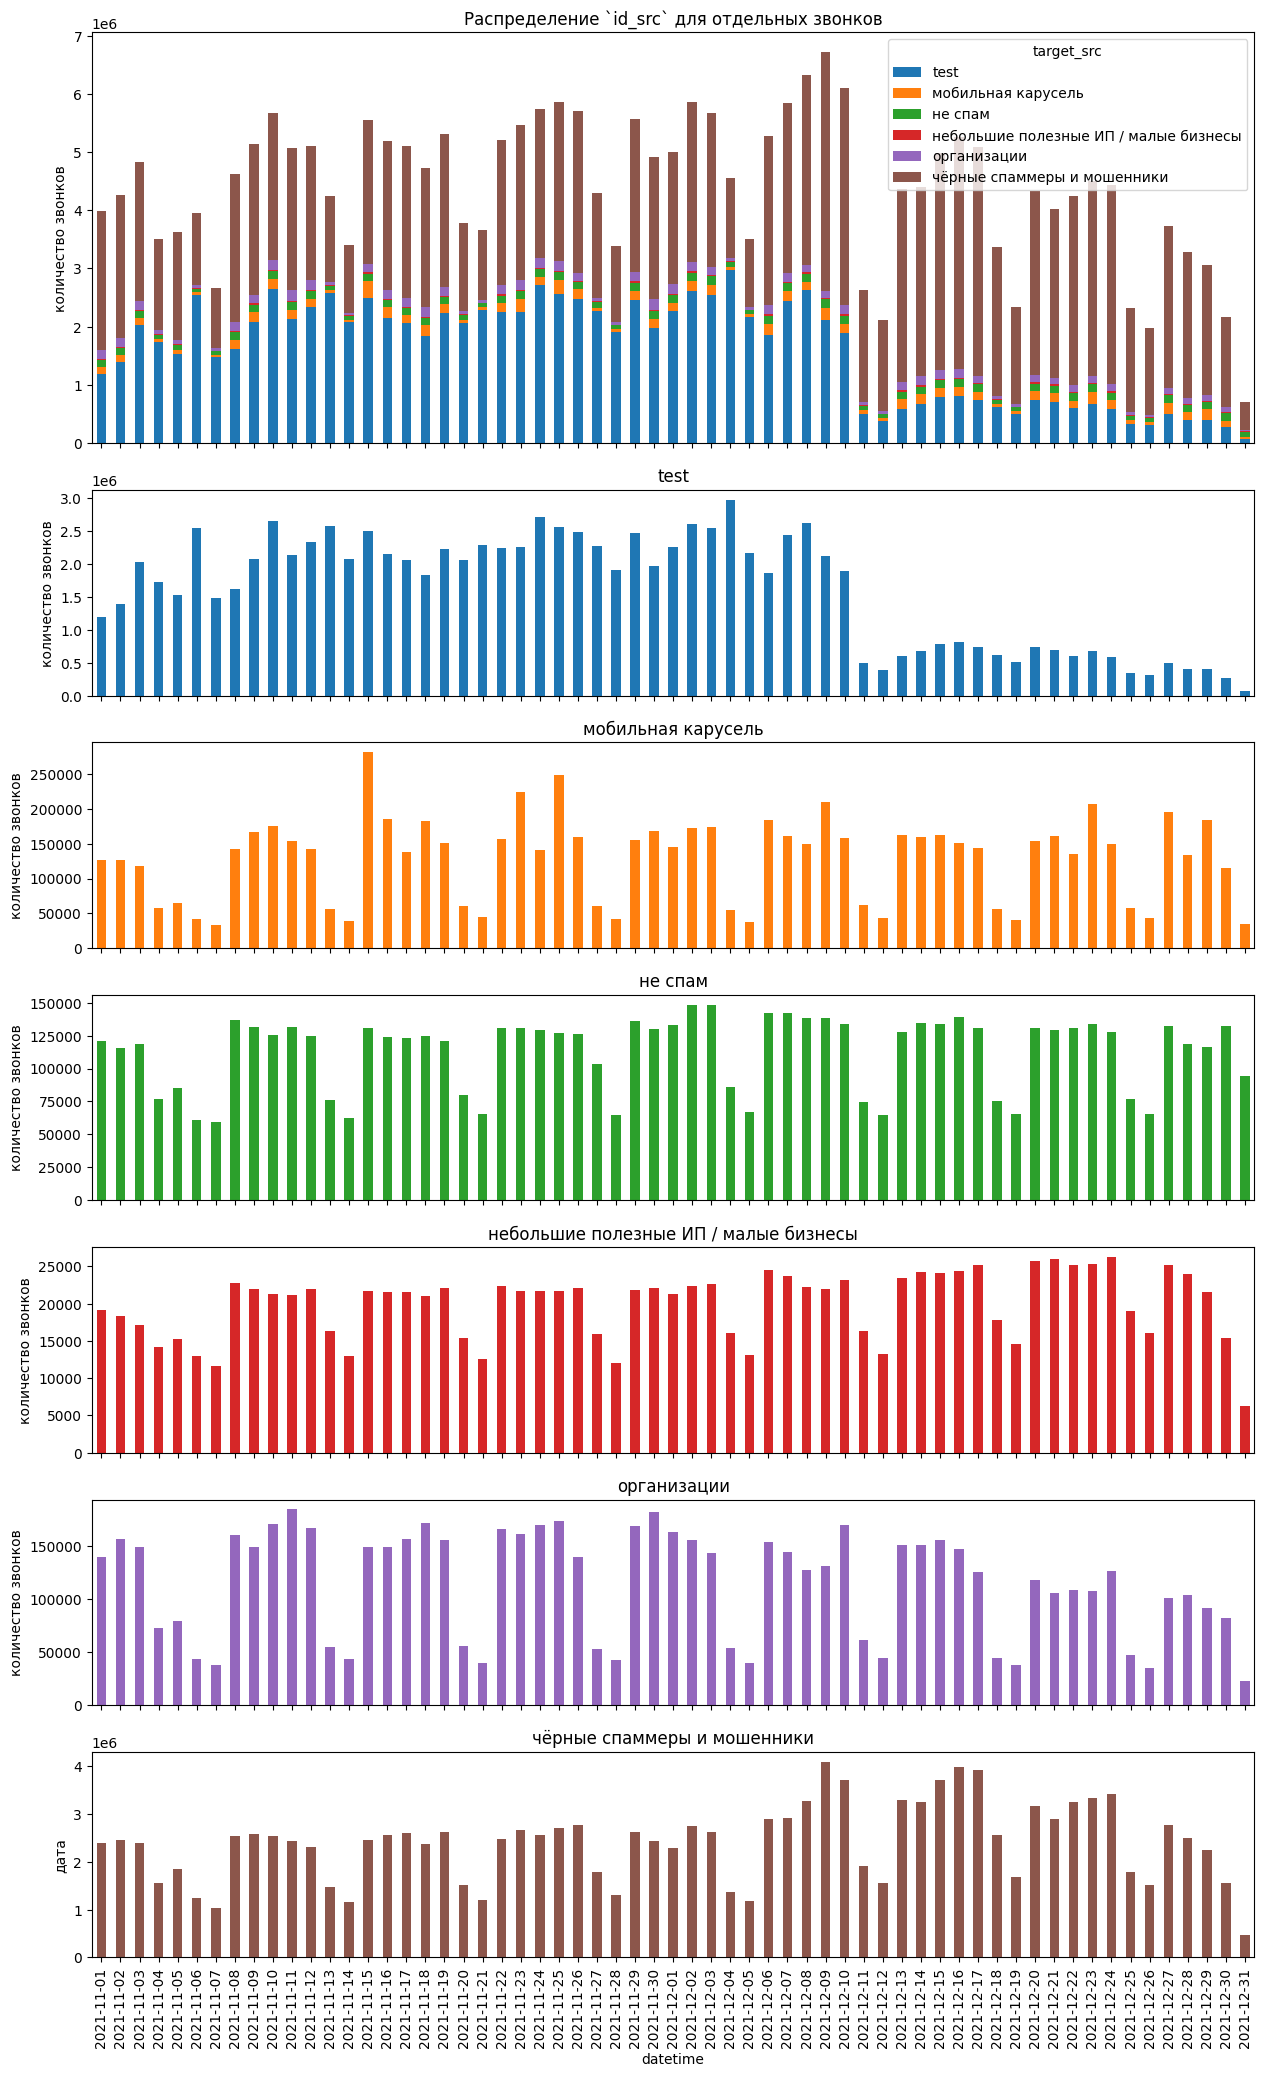

In [9]:
grouped =  (
    data
    .groupby([pd.Grouper(key="datetime", freq="D"), "target_src"])
    ["time_zone"]
    .count()
    .unstack()
)

fig, axes = plt.subplots(
    7, 1,
    figsize=(15, 25),
    gridspec_kw={"height_ratios": [2, 1, 1, 1, 1, 1, 1]},
    sharex=True,
)

grouped.plot(
    kind="bar",
    stacked=True,
    color=COLORS,
    title="Распределение `id_src` для отдельных звонков",
    ax=axes[0],
)
for ax, label, color in zip(axes[1:], grouped.columns, COLORS):
    grouped[label].plot(kind="bar", color=color, title=label, ax=ax)
for ax in axes:
    ax.set(ylabel="количество звонков")
axes[-1].set_xticklabels(grouped.index.format(), rotation=90)
axes[-1].set_ylabel("дата")

plt.show()

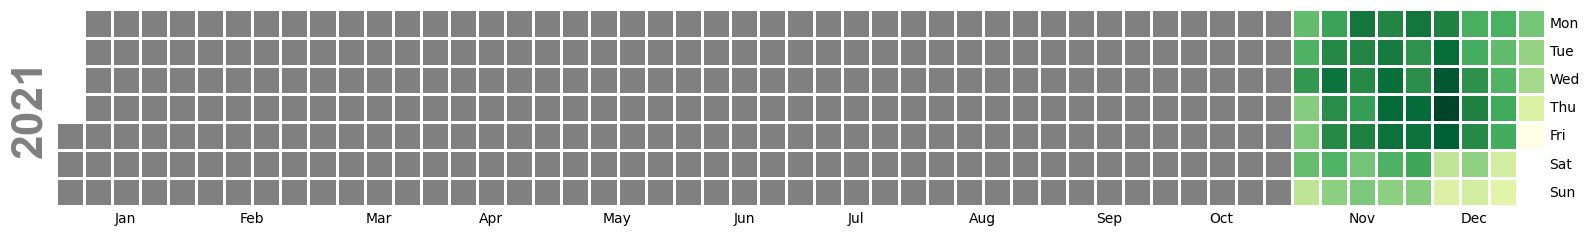

In [10]:
grouped =  (
    data
    .groupby(pd.Grouper(key="datetime", freq="D"))
    ["time_zone"]
    .count()
)

# TODO: здесь не работают почему-то параметры `monthlabels` и `monthticks`
# может стоит залезть в исходный код
# https://pythonhosted.org/calmap/
# хотелось вывести только 2 необходимых месяца
fig, axes = calmap.calendarplot(
    grouped,
    fig_kws={'figsize': (16, 10)},
    fillcolor='gray',
    cmap='YlGn',
)

## Анализ распределения входящих звоноков по дням и целевым классам

C:\Users\karinoizerr\AppData\Local\Temp\ipykernel_7936\467466038.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([pd.Grouper(key="datetime", freq="D"), "target_dst"])
C:\Users\karinoizerr\AppData\Local\Temp\ipykernel_7936\467466038.py:27: FutureWarning: DatetimeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  axes[-1].set_xticklabels(grouped.index.format(), rotation=90)


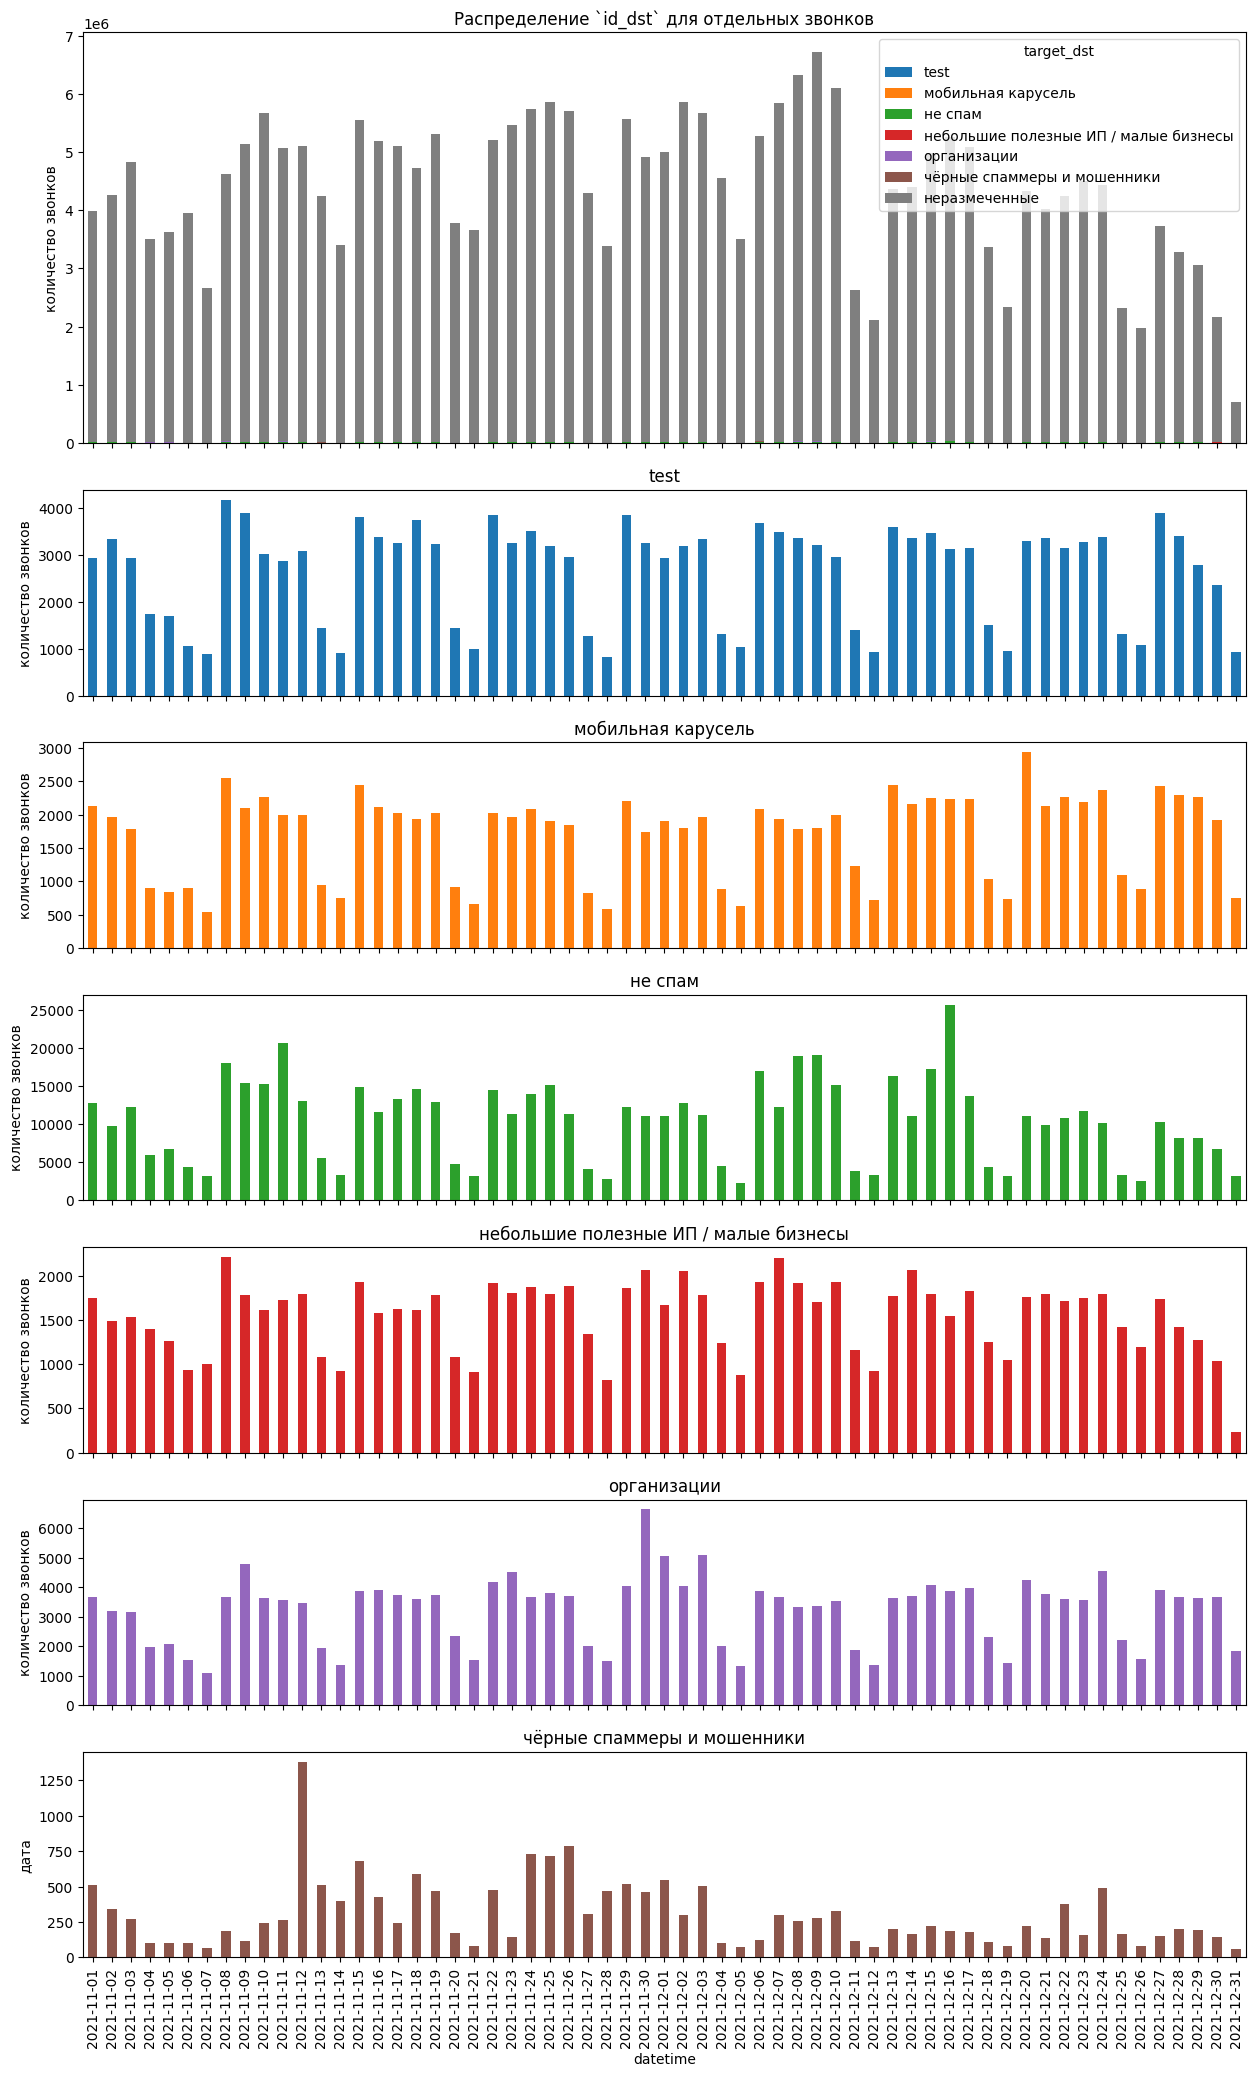

In [12]:
grouped =  (
    data
    .groupby([pd.Grouper(key="datetime", freq="D"), "target_dst"])
    ["time_zone"]
    .count()
    .unstack()
)

fig, axes = plt.subplots(
    7, 1,
    figsize=(15, 25),
    gridspec_kw={"height_ratios": [2, 1, 1, 1, 1, 1, 1]},
    sharex=True,
)

grouped.plot(
    kind="bar",
    stacked=True,
    color=COLORS,
    title="Распределение `id_dst` для отдельных звонков",
    ax=axes[0],
)
for ax, label, color in zip(axes[1:], grouped.columns, COLORS):
    grouped[label].plot(kind="bar", color=color, title=label, ax=ax)
for ax in axes:
    ax.set(ylabel="количество звонков")
axes[-1].set_xticklabels(grouped.index.format(), rotation=90)
axes[-1].set_ylabel("дата")

plt.show()

## Анализ распределения звонящих клиентов по дням и целевым классам

C:\Users\karinoizerr\AppData\Local\Temp\ipykernel_7936\3275010069.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([pd.Grouper(key="datetime", freq="D"), "target_src"])
C:\Users\karinoizerr\AppData\Local\Temp\ipykernel_7936\3275010069.py:28: FutureWarning: DatetimeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  axes[-1].set_xticklabels(grouped.index.format(), rotation=90)


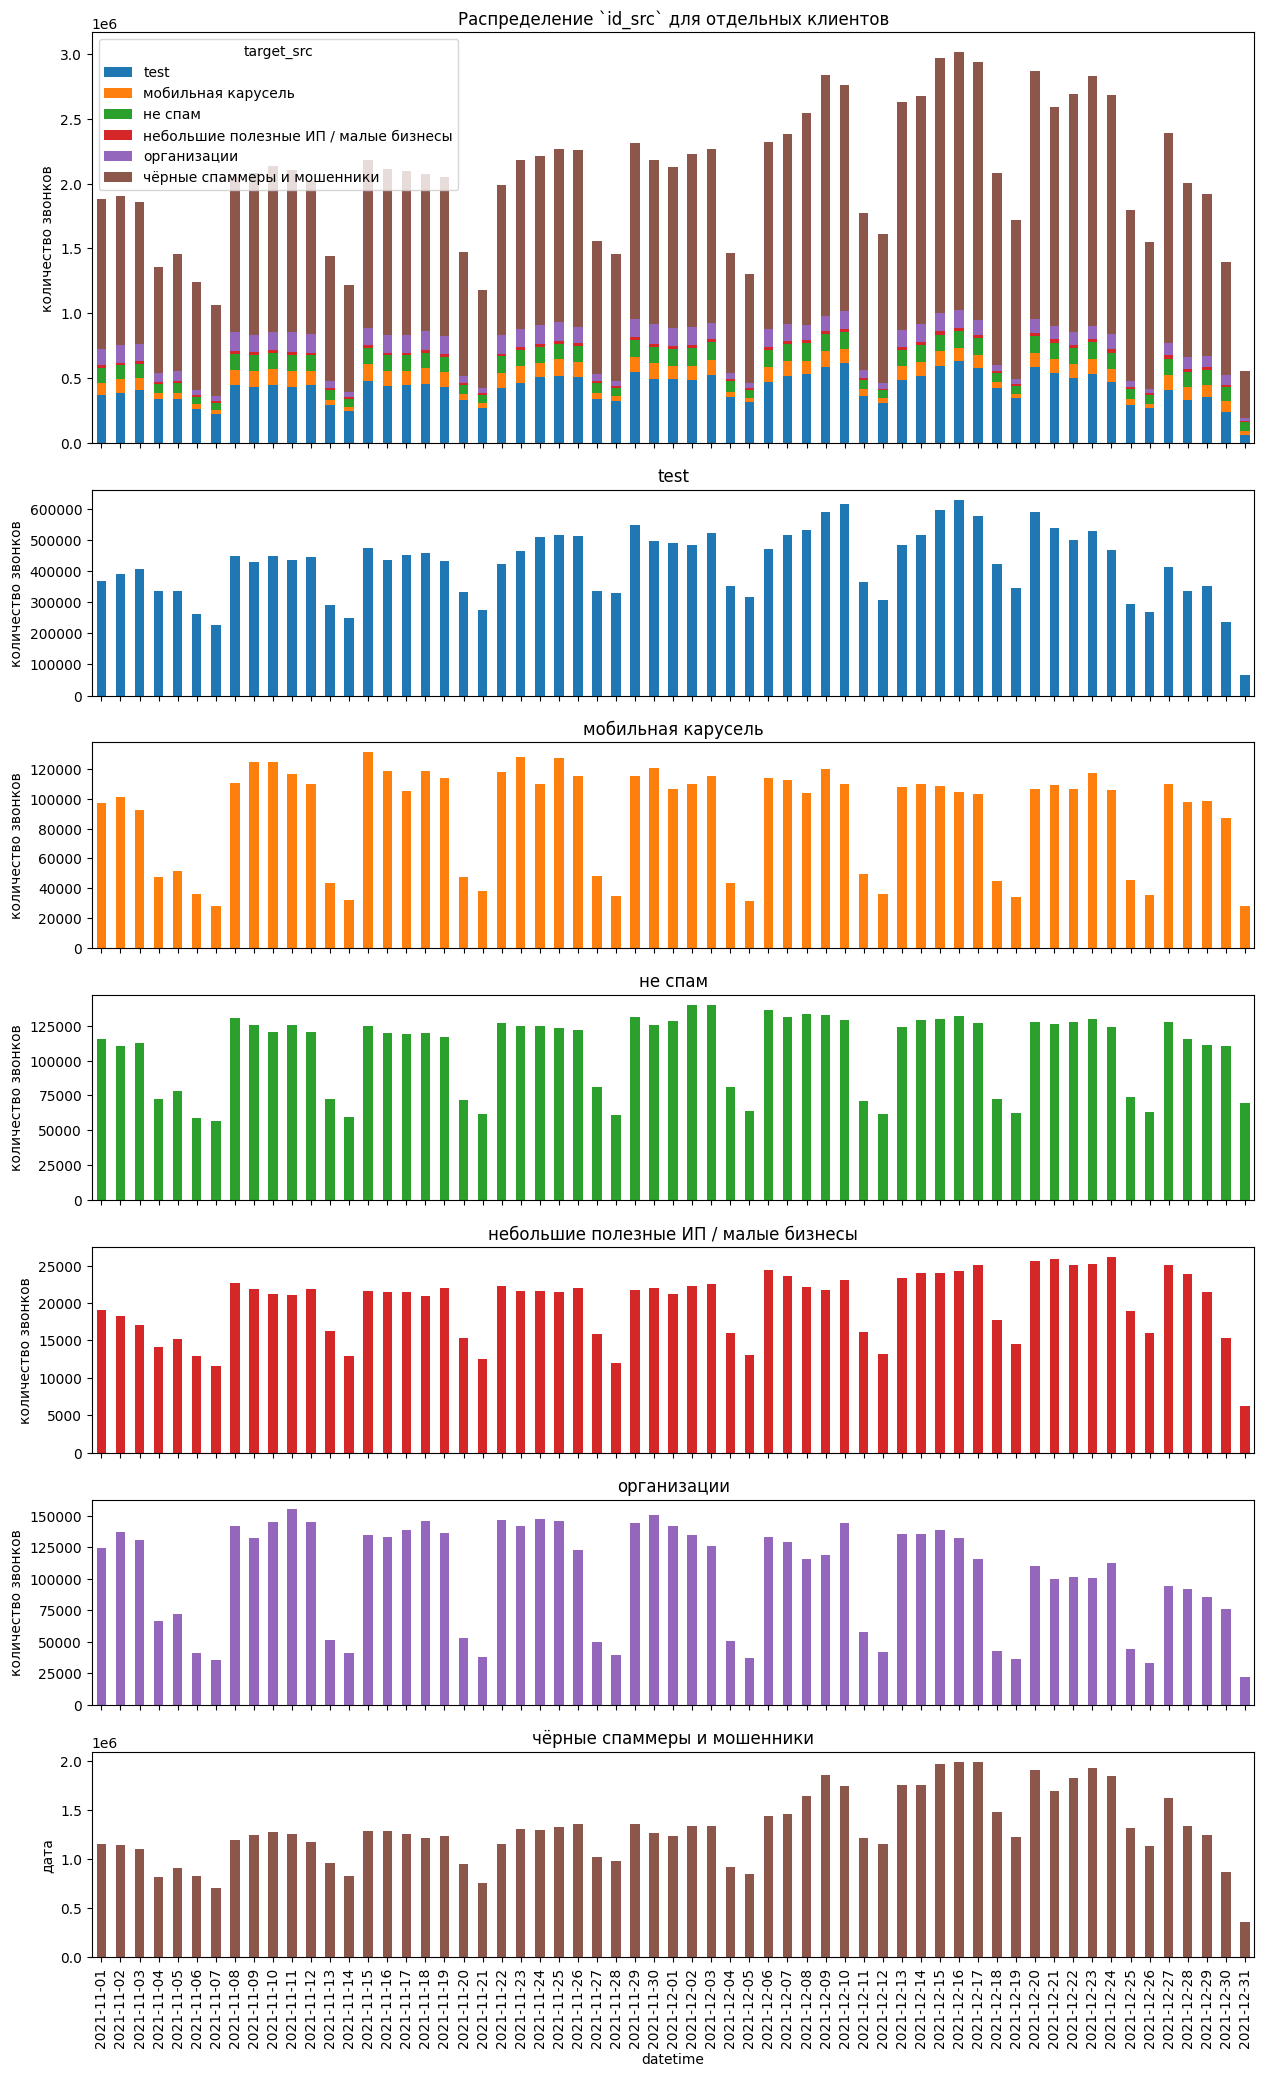

In [30]:
grouped = (
    data[["id_src", "datetime", "target_src"]]
    .drop_duplicates()
    .groupby([pd.Grouper(key="datetime", freq="D"), "target_src"])
    ["id_src"]
    .count()
    .unstack()
)

fig, axes = plt.subplots(
    7, 1,
    figsize=(15, 25),
    gridspec_kw={"height_ratios": [2, 1, 1, 1, 1, 1, 1]},
    sharex=True,
)

grouped.plot(
    kind="bar",
    stacked=True,
    color=COLORS,
    title="Распределение `id_src` для отдельных клиентов",
    ax=axes[0],
)
for ax, label, color in zip(axes[1:], grouped.columns, COLORS):
    grouped[label].plot(kind="bar", color=color, title=label, ax=ax)
for ax in axes:
    ax.set(ylabel="количество звонков")
axes[-1].set_xticklabels(grouped.index.format(), rotation=90)
axes[-1].set_ylabel("дата")

plt.show()